In [1]:
import numpy as np
from EM import EM
from plot import plot
import matplotlib.pyplot as plt
import pickle

In [2]:
signal_context = {}

In [3]:
signal_name = 'creatinine'

treatment_names = {}
treatment_names['dialysis'] = ['dialysis'] 
treatment_names['nephrotoxic_drugs'] = ['acetaminophen_dose','celecoxib_dose','diclofenac_dose','ibuprofen_dose','indomethacin_dose',
'ketorolac_dose','meloxicam_dose','naproxen_dose']
treatment_names['dronedarone'] = ['dronedarone_dose']
treatment_names['diuretic'] = ['eplerenone_dose', 'amiloride_dose', 'hydrochlorothiazide_dose',
'spironolactone_dose', 'triamterene_dose', 'chlorothiazide_dose', 'indapamide_dose', 'torsemide_dose', 
'acetazolamide_dose', 'mannitol_dose']
treatment_names['ace_i'] = ['lisinopril_dose',
 'ramipril_dose',
 'benazepril_dose',
 'enalaprilat_dose',
 'captopril_dose',
 'perindopril_dose',
 'trandolapril_dose']
treatment_names['arb'] = ['valsartan_dose',
 'telmisartan_dose',
 'irbesartan_dose',
 'losartan_dose',
 'candesartan_dose']

#treatment_names['search'] = ['losartan']

chronic_keywords = ['chronic_kidney', 'kidney_cancer', 'renal', 'esrd', 'sickle_cell']

demographic_names = ['gender', 'admit_weight']
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [4]:
signal_name = 'inr'

treatment_names = {}
treatment_names['nsaid'] = ['acetaminophen_dose','celecoxib_dose','diclofenac_dose','ibuprofen_dose','indomethacin_dose',
'ketorolac_dose','meloxicam_dose','naproxen_dose', 'aspirin_dose']
treatment_names['anticoagulant'] = ['warfarin_dose','heparin_dose','dabigatran_dose','edoxaban_dose','rivaroxaban_dose',
'apixaban_dose','enoxaparin_dose','dalteparin_dose','fondaparinux_dose']
treatment_names['transfusion_platelets'] = ['transfuse_platelets']

chronic_keywords = ['liver_disease', 'sickle_cell']

demographic_names = []

signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [5]:
signal_name = 'platelets'
treatment_names = {}
treatment_names['platelets_transfusion'] = ['transfuse_platelets']
treatment_names['ditp'] = ['ibuprofen_dose',
 'acetaminophen_dose',
 'ampicillin_dose',
 'heparin_dose',
 'vancomycin_dose',
 'piperacillin_tazobac_dose',
 'naproxen_dose']

chronic_keywords = ['liver', 'sickle_cell']
demographic_names = []
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [6]:
signal_name = 'lactate'
treatment_names = {}
treatment_names['ivf'] = ['crystalloid_fluid', 'crystalloid_fluid_order']
treatment_names['antibiotics'] = ['vancomycin_dose',
'piperacillin_tazobac_dose',
'ceftriaxone_dose',
'meropenem_dose',
'cefotaxime_dose', 'gentamicin_dose', 'ceftazidime_dose', 'amikacin_dose',
'amphotericin_b_ambisome_dose', 'amphotericin_b_fungizone_dose']
treatment_names['drugs_elevate_lactate'] = ['acetaminophen_dose',
 'epinephrine_dose',
 'propofol_dose',
 'theophylline_dose',
 'betaxolol_dose',
 'metformin_dose','albuterol_dose', 'salmeterol_dose']

#treatment_names['search'] = ['cocaine']

chronic_keywords = ['chronic_kidney', 'kidney_cancer', 'renal', 'esrd', 'diabete', 'liver']
demographic_names = []
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [7]:
signal_name = 'bun'
treatment_names = {}
treatment_names['dialysis'] = ['dialysis'] 
treatment_names['diuretic'] = ['eplerenone_dose', 'amiloride_dose', 'hydrochlorothiazide_dose',
'spironolactone_dose', 'triamterene_dose', 'chlorothiazide_dose', 'indapamide_dose', 'torsemide_dose', 
'acetazolamide_dose', 'mannitol_dose']
treatment_names['drugs_increase'] = ['vancomycin_dose',
 'furosemide_dose',
 'carbamazepine_dose',
 'rifampin_dose',
 'hydrochlorothiazide_dose',
 'spironolactone_dose',
 'methotrexate_dose',
 'chlorothiazide_dose',
 'methyclothiazide_dose',
 'amphotericin_b_ambisome_dose',
 'amphotericin_b_fungizone_dose',
 'cefazolin_dose',
 'ceftriaxone_dose',
 'ceftazidime_dose',
 'cefuroxime_dose',
 'cefotaxime_dose']

chronic_keywords = ['chronic_kidney', 'kidney_cancer', 'renal', 'esrd', 'heart_failure', 'liver']

demographic_names = []
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [8]:
# EM Setting
training_pct = .8
single_effect = False

In [ ]:
%%time
all_signals = ['creatinine', 'bun']#, 'lactate', 'platelets', 'inr']
past_effects = [2, 2, 2, 2, 3]
all_params = {}

for s, signal_name in enumerate(all_signals):
    num_past_effects = past_effects[s]
    treatment_names, chronic_keywords, demographic_names = signal_context[signal_name]
    data = np.load('../Data/'+signal_name+'_preprocessed_data.npz')
    
    num_iter = 1 # number of iterations to average over coefficients
    # store coefficients averaged over multiple runs of EM
    A = np.zeros((num_iter, num_past_effects, len(treatment_names.keys())))
    b = np.zeros((num_iter, len(chronic_keywords) + len(demographic_names)))
    transition_std = np.zeros(num_iter)
    observation_std = np.zeros(num_iter)
    initial_state_std = np.zeros(num_iter)
    initial_state_mean = np.zeros(num_iter)
    mse = []
    loglik = []
    intercept = []

    for i in range(num_iter):
        em = EM(data['y_mtx'], data['X_mtx'], data['c_mtx'], num_past_effects, K=0, train_pct=training_pct, X_prev_given=True,
            X_prev = data['X_prev_mtx'], single_effect=single_effect)
        em.run_EM(2000)
        A[i, :, :] = em.A
        b[i, :] = em.b
        initial_state_mean[i] =  em.init_z
        initial_state_std[i] = np.sqrt(em.sigma_0)
        transition_std[i] = np.sqrt(em.sigma_1)
        observation_std[i] = np.sqrt(em.sigma_2)
        mse.append(em.mse)
        loglik.append(em.obs_log_lik)
        intercept.append(em.intercept)
        print('Finish run {} for {}'.format(i+1, signal_name))
        
    all_params[signal_name] = [A, b, initial_state_mean, initial_state_std, transition_std, observation_std, mse, loglik, intercept]

#pickle.dump(all_params, open('../Data/est_params.pkl', 'wb'))

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

iteration 594
iteration 595
iteration 596
iteration 597
iteration 598
iteration 599
iteration 600
iteration 601
iteration 602
iteration 603
iteration 604
iteration 605
iteration 606
iteration 607
iteration 608
iteration 609
iteration 610
iteration 611
iteration 612
iteration 613
iteration 614
iteration 615
iteration 616
iteration 617
iteration 618
iteration 619
iteration 620
iteration 621
iteration 622
iteration 623
iteration 624
iteration 625
iteration 626
iteration 627
iteration 628
iteration 629
iteration 630
iteration 631
iteration 632
iteration 633
iteration 634
iteration 635
iteration 636
iteration 637
iteration 638
iteration 639
iteration 640
iteration 641
iteration 642
iteration 643
iteration 644
iteration 645
iteration 646
iteration 647
iteration 648
iteration 649
iteration 650
iteration 651
iteration 652
iteration 653
iteration 654
iteration 655
iteration 656
iteration 657
iteration 658
iteration 659
iteration 660
iteration 661
iteration 662
iteration 663
iteration 664
iterat

In [ ]:
#all_params = pickle.load(open('../Data/est_params.pkl', 'rb'))
for signal_name in all_signals:
    learned_params = all_params[signal_name]
    A = learned_params[0]
    b = learned_params[1]
    initial_state_mean = learned_params[2]
    initial_state_std = learned_params[3]
    transition_std = learned_params[4]
    observation_std = learned_params[5]
    intercept = learned_params[8]
    treatment_names, chronic_keywords, demographic_names = signal_context[signal_name]
    print('{} coefficients averaged over {} runs'.format(signal_name, num_iter))
    for i, treatment in enumerate(treatment_names.keys()):
        print('Coefficient for {}: {}'.format(treatment, np.round(np.average(A, axis=0)[:, i], 4)))
    static_types = chronic_keywords + demographic_names
    for j, static in enumerate(static_types):
        print('Coefficient for {}: {}'.format(static, np.round(np.average(b, axis=0)[j], 4)))
    print('initial state mean: {}'.format(np.round(np.average(initial_state_mean), 4)))
    print('initial state std: {}'.format(np.round(np.average(initial_state_std), 4)))
    print('transition noise (std): {}'.format(np.round(np.average(transition_std), 4)))
    print('observation noise (std): {}'.format(np.round(np.average(observation_std), 4)))
    print('intercept: {}'.format(np.round(np.average(intercept), 8)))
    print('')

In [ ]:
for signal_name in all_signals:
    loglik = all_params[signal_name][7][2]
    plt.plot([i for i in range(len(loglik))], loglik)
    plt.xlabel('Iterations')
    plt.ylabel('Observed data log likelihood')
    plt.title('EM log likelihood of {}'.format(signal_name))
    plt.show()

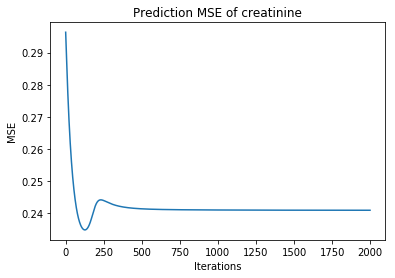

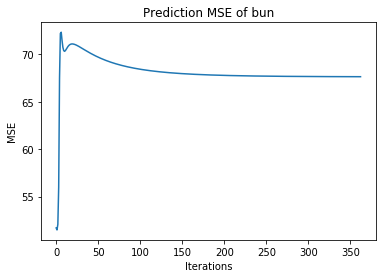

In [13]:
for signal_name in all_signals:
    mse = all_params[signal_name][6][2]
    plt.plot([i for i in range(len(mse))], mse)
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.title('Prediction MSE of {}'.format(signal_name))
    plt.show()

In [14]:
for signal_name in all_signals:
    learned_params = all_params[signal_name]
    A = learned_params[0]
    b = learned_params[1]
    initial_state_mean = learned_params[2]
    initial_state_std = learned_params[3]
    transition_std = learned_params[4]
    observation_std = learned_params[5]
    treatment_names, chronic_keywords, demographic_names = signal_context[signal_name]
    print('{} coeffients std'.format(signal_name))
    for i, treatment in enumerate(treatment_names.keys()):
        print('Coefficient for {}: {}'.format(treatment, np.round(np.std(A, axis=0)[:, i], 4)))
    static_types = chronic_keywords + demographic_names
    for j, static in enumerate(static_types):
        print('Coefficient for {}: {}'.format(static, np.round(np.std(b, axis=0)[j], 4)))
    print('initial state mean: {}'.format(np.round(np.std(initial_state_mean), 4)))
    print('initial state std: {}'.format(np.round(np.std(initial_state_std), 4)))
    print('transition noise (std): {}'.format(np.round(np.std(transition_std), 4)))
    print('observation noise (std): {}'.format(np.round(np.std(observation_std), 4)))
    print('')

creatinine coeffients std
Coefficient for dialysis: [0.003  0.0258]
Coefficient for nephrotoxic_drugs: [0.0015 0.0012]
Coefficient for dronedarone: [0.0022 0.0057]
Coefficient for diuretic: [0.0034 0.0034]
Coefficient for ace_i: [0.0045 0.0039]
Coefficient for arb: [0.0041 0.0021]
Coefficient for chronic_kidney: 0.0671
Coefficient for kidney_cancer: 0.0793
Coefficient for renal: 0.0046
Coefficient for esrd: 0.1015
Coefficient for sickle_cell: 0.0214
Coefficient for gender: 0.035
Coefficient for admit_weight: 0.0082
initial state mean: 0.658
initial state std: 0.1883
transition noise (std): 0.0224
observation noise (std): 0.0461

bun coeffients std
Coefficient for dialysis: [0.0349 0.0217]
Coefficient for diuretic: [0.0354 0.0141]
Coefficient for drugs_increase: [0.2991 0.1851]
Coefficient for chronic_kidney: 0.4625
Coefficient for kidney_cancer: 0.1333
Coefficient for renal: 0.0068
Coefficient for esrd: 0.1571
Coefficient for heart_failure: 0.2961
Coefficient for liver: 0.4962
initial 

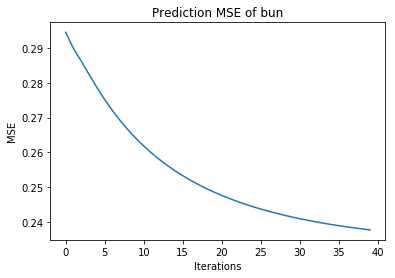

In [15]:
plt.plot([i for i in range(len(em.mse))], em.mse)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Prediction MSE of {}'.format(signal_name))
plt.show()

In [16]:
for i, treatment in enumerate(treatment_names.keys()):
    print('Coefficient for {}: {}'.format(treatment, np.round(em.A[:, i], 4)))
static_types = chronic_keywords + demographic_names
for j, static in enumerate(static_types):
    print('Coefficient for {}: {}'.format(static, np.round(em.b[j], 4)))
print('initial state mean: {}'.format(round(em.init_z, 4)))
print('initial state std: {}'.format(round(np.sqrt(em.sigma_0), 4)))
print('transition noise (std): {}'.format(round(np.sqrt(em.sigma_1), 4)))
print('observation noise (std): {}'.format(round(np.sqrt(em.sigma_2), 4)))

Coefficient for dialysis: [-1.1814 -0.5579]
Coefficient for diuretic: [-0.0049 -0.0121]
Coefficient for drugs_increase: [-0.0497  0.0899]
Coefficient for chronic_kidney: 0.0705
Coefficient for kidney_cancer: -0.0103
Coefficient for renal: 0.0429
Coefficient for esrd: 0.1971
Coefficient for heart_failure: 0.0367
Coefficient for liver: -0.0001
initial state mean: 0
initial state std: 3.4257
transition noise (std): 0.4246
observation noise (std): 0.1096


In [17]:
patient_index = 0
y_mtx = data['y_mtx'][patient_index, :]
X_mtx = data['X_mtx'][patient_index, :, :]
c_mtx = data['c_mtx'][patient_index, :]
X_prev_mtx = data['X_prev_mtx'][patient_index, :, :]
y_mtx = y_mtx[np.newaxis, :]
X_mtx = X_mtx[np.newaxis, :, :]
c_mtx = c_mtx[np.newaxis, :]
X_prev_mtx = X_prev_mtx[np.newaxis, :, :]

In [18]:
converge = np.array(em.sos)
initial = np.array(a)

NameError: name 'a' is not defined

In [ ]:
diff = converge - initial

In [ ]:
np.argsort(diff)[-30:]

In [ ]:
random_patients = np.random.randint(0, em.y.shape[0], 20)
for i in random_patients:
    plot(em, i, 12, signal_name, treatment_types=list(treatment_names.keys()))

### Analysis
Changes
* Only select patients with at least 4 training observations (total of 1821)

On real data
* Issues:
    * treatments coefficients are negative while they should be positive
        * changing initialization doesn't seem to help as model converges in bad local min, and most directions still don't change
    * observation noise is bigger than transition noise
    * run time is long, each iteration takes 4s, M step takes 2.5s, loglik takes 1s
* Reasons:
    * The increasing effects of treatments are not pronouced in the data (see Source Data Analysis)
        * it makes sense that nsaid and aspirin shows small number close to zero since their effects are 50-50.
        * transfusion platelet should be more negative than others, also makes sense.
        * the first number for plasma is a very negative number, but should be close to zero
        * anticoagulant are more negative than platelet, but should be more similar
    * bad noise estimation is expected, specifically underestimated initial state variance and overestimated observational noise 
    
On simulation
* Issues
    * b seems to be harder to identify correctly compared to A (sensitive to initialization)
    * estimated sigma 0 and sigma 2 are very different from the true value (not sensitive to initialization)
        * underestimate sigma 0, overestimate sigma 2
* Reasons
   